# Classification Models

_This "worksheet" is mostly textbook/walkthrough content. The exercises are at the end but rely on the proceeding material._

A **classification model** is when you're predicting an outcome with discrete levels. It can be binary (default vs paid off), or multinomial (red, orange, yellow, green, blue, indigo, violet).

[Classification is best divided into two parts:](https://scikit-learn.org/stable/modules/classification_threshold.html#)
1. the statistical problem of learning a model to predict, ideally, class probabilities;
2. the decision problem to take concrete action based on those probability predictions.

We actually estimated a classification model in the last worksheet: Did borrowers pay back a loan?

We did this by estimating a logitistic (logit) regression. 

A fitted logit model produces, for a given vector of data X, the predicted probability that y=1 for those values of X.

This is not a classification, its a probability, a number in [0,1]. 

A _classification model that uses logit_ takes the logit predicted probability, and outputs a prediction: YES, or NO. 

It does this by setting a **threshold** T: If the predicted probability is above T, then the prediction is YES. 

## In this worksheet:

- [ ] Ways to evaluate classifications models
    - You can output a classification report and key diagnostics
    - You can use and interpret those outputs
- [ ] The problem of imbalanced data
- [ ] Thinking about the objective: what to maximize and/or minimize in your model   
    

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 50, "display.max_columns", None
)

## Load data 

In [2]:
loans = pd.read_csv('inputs/2013_subsample.zip')

## Create the training and holdout samples

Here, we will use `test_train_split`, though this might not 

In [3]:
# first let's separate y from X (as is typically done)
y = loans.loan_status == "Charged Off"
y.value_counts()
loans = loans.drop("loan_status", axis=1)

# stratify will make sure that test/train both have equal fractions of outcome
X_train, X_test, y_train, y_test = train_test_split(
    loans, y, stratify=y, test_size=0.2, random_state=0
)

## Setting up _one_ classification model

_Note: `preproc_pipe` is the exact same as last time, but I've defined it in a different (easier?) way, and I've named the whole pipeline `clf_logit`_

In [4]:
# set up pipeline to clean each type of variable (1 pipe per var type)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder(drop="first"))

# combine those (make_column_transformer is like make_pipeline, maybe easier on the eyes!)

preproc_pipe = make_column_transformer(
    (numer_pipe, ["annual_inc", "int_rate"]),
    (cat_pipe, ["grade"]),
    remainder="drop",
)

# estimator

clf_logit = make_pipeline(preproc_pipe, LogisticRegression())

I'm going to fit it to the whole training dataset. This means what we're about to learn is being done without CV for now, and will likely result in overconfident performance metrics.

In [5]:
clf_logit.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['annual_inc', 'int_rate']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['grade'])])),
                ('logisticregression', LogisticRegression())])

## Evaluating the classification model

First, we cover the classic "ML" model evaluation outputs. These aren't made for business settings, but are useful.  

1. Calibration Display: Is your model producing well-tuned probabilities?
1. Classification report
2. Confusion Matrix
4. Precision-Recall Curve: Can your model have high recall and precision if we adjust the threshold?
5. ROC Curve: Can your model have low false positives and high recall if we adjust the threshold? 


### Calibration display

Our logit estimator produces, for each loan, a prediction of the probability of default. A calibration display groups those predictions into buckets (on the x-axis), and reports the average true outcomes for that bucket (on the y-axis). A perfectly calibrated classifier will be on the 45 degree line.

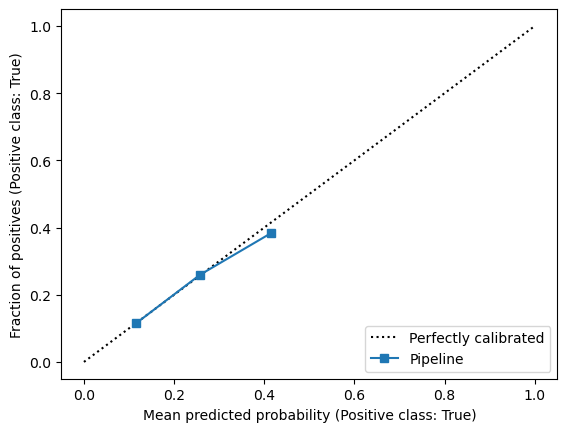

In [6]:
CalibrationDisplay.from_estimator(clf_logit, X_train, y_train)

This figure suggests that our logit seems to be decently "calibrated".

This means the *estimation model* is decent, and that the *classifier* _can_ be good.

This does not mean the classifier is good. 



### Classification Report

**When you build a classifier, you should always output a `classification_report`.**

_Ignore the Warnings. This table is correct. It's just mad that our model is so bad we never predict a default!_

The definition of precision and recall and f1-score [are here.](https://ledatascifi.github.io/ledatascifi-2022/content/05/03d_whatToMax.html)

First I explain the terms abstractly, and after the table, I'll rephase them in more direct language.
- Precision measures: When we predict an outcome, how often does that happen? (Are the predictions precise?)
- Recall: What fraction of an outcome's occurrences does your model detect? ("Does the model recall the true occurrences?")
    - Aka sensitivity: A sensitive model detects an outcome happening more often
- Accuracy: Fraction of labels that are correct across all observations
- `macro_avg`: Simple average of the stats above the blank line.
    - The average of the precision in the False and True observations here (0.84 and 0) is 0.42
- `weighted_avg`: Average of the stats above the blank line, weighted by the number of observations in each outcome type


In [7]:
print(classification_report(y_train, 
                            clf_logit.predict(X_train)))

              precision    recall  f1-score   support

       False       0.84      1.00      0.92     91024
        True       0.00      0.00      0.00     16819

    accuracy                           0.84    107843
   macro avg       0.42      0.50      0.46    107843
weighted avg       0.71      0.84      0.77    107843



c:\Users\DonsLaptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DonsLaptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DonsLaptop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Above: We get Precision and Recall for each class. Let's translate those metrics into business words:

- False (paid back) precision: When our model predicts a loan will be paid back, how many actually were? (84%)
- True (charge off) precision: When our model predicts a loan will be charged off, how many actually were? (0%)

- False (paid back) recall: What fraction of the paid off loans does our model predict would be? (100%)
- True (charge off) recall: What fraction of the charged off loans does our model predict would be? (0%)


### Confusion Matrix

**You should also output a Confusion Matrix, which is a standard way to display how a classifier is doing.**
- If you add `normalize='pred'` to the function below, the diagonal elements are your precisions.
- If you add `normalize='true'` to the function below, the diagonal elements are your recalls.

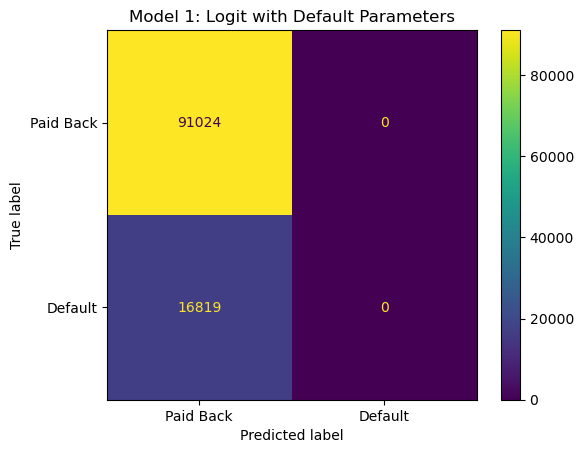

In [8]:
ConfusionMatrixDisplay.from_estimator(clf_logit, X_train, y_train, display_labels=["Paid Back", "Default"])
plt.title('Model 1: Logit with Default Parameters')
plt.show()


So even though our logit seems to be decently calibrated, it is performing AWFULLY in terms of precision and recall on predicting defaults, because it never predict a default.

What gives? 

Remember, 
> - A **classification model** is when you're predicting an outcome with discrete levels and [is best divided into two parts:](https://scikit-learn.org/stable/modules/classification_threshold.html#)
>   1. the statistical problem of learning a model to predict, ideally, class probabilities;
>   2. the decision problem to take concrete action based on those probability predictions.



### "Decision functions"

Here's what happens:


In [9]:
blah = '''
==============================================================================
          A flow chart from our model to the final predictions:
==============================================================================

logit     >      ahat,           >             yhat           >         {0,1}
                 bhat                        Pr(y=1|X)
      ----------        --------------------           --------------
      | .fit() |        | .predict_proba() |           | .predict() |
      |        |        |  uses ahat bhat  |           |   uses  ?  |
      ----------        --------------------           --------------

'''

That last step, `.predict()` uses a **"decision function"** that turns the yhat values (predicted probabilities) into predictions. 

The **"default threshold"** in `sklearn` for logit is 0.5:
- If yhat>0.5: predict outcome = 1 
- Else: predict outcome = 0


**You don't need to use the default threshold! The threshold is a choice a researcher needs to make, as it involves important tradeoffs.**

In practice, how you make the choice depends on whether your business problem has larger costs for false positives, false negative, or larger benefits for true positives and true negatives.

The next set of diagnostics help you see how changing the threshold can change the performance of the model and assess these tradeoffs.

### Precision-Recall Curves 

This takes all the predicted probabilities the model produces, and pretends we set a threshold of 0.01, 0.02, ... 0.99. For each possible threshold, compute the **precision and recall** of the predictions, and then plot them all.

Sklearn has a function to do this all at once, which I'll show next, but I want to show you how it's being made under the hood to highlight what the figure shows:

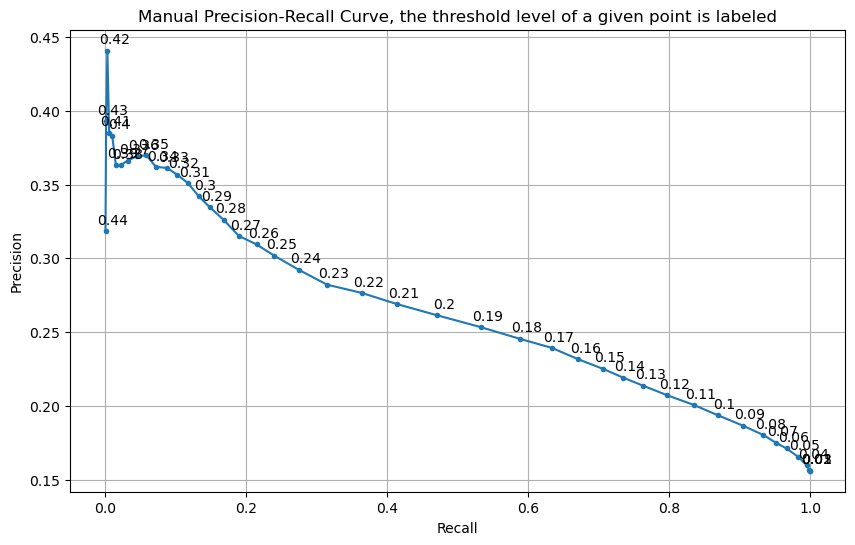

In [10]:
# Get the predicted probabilities for the positive class
y_prob = clf_logit.predict_proba(X_train)[:, 1]

# Calculate precision and recall values at different thresholds
thresholds = np.arange(0.01, 0.45, 0.01)
precision = []
recall = []

for threshold in thresholds:

    # At this threshold, if the model's predicted probability
    # is greater than the threshold, classify as positive
    y_pred_threshold = (y_prob >= threshold) 
    
    # Calculate precision and recall
    # precision_val = true positives / predicted_true
    # recall_val = true positives / actually_true

    tp = np.sum((y_train == True) & (y_pred_threshold == True))
    predicted_true = np.sum(y_pred_threshold == True)
    actually_true = np.sum(y_train == True)
    
    precision_val = tp / predicted_true if predicted_true > 0 else 0
    recall_val = tp / actually_true if actually_true > 0 else 0
    
    precision.append(precision_val)
    recall.append(recall_val)

precision = np.array(precision)
recall = np.array(recall)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall curve')

# Annotate the points with their corresponding thresholds
for xi, yi, zi in zip(recall,precision,thresholds):
    plt.annotate(
        round(zi,2),                     # Annotation text (z value)
        (xi, yi),              # Point to annotate
        textcoords="offset points",  # How to position the text
        xytext=(5, 5),         # Offset: 5 points to the right and 5 points up
        ha='center'            # Horizontal alignment of text
    )

# Add labels, title and grid
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Manual Precision-Recall Curve, the threshold level of a given point is labeled')
plt.grid(True)

plt.show()

In general, this curve will be sloped downwards **because precision and recall are a tradeoff:**
- As you increase the threshold, you'll reduce false positives (more precision) because you only predict default for loans you're very confident will default
- But as you increase the threshold, you'll predict fewer defaults, meaning you'll miss some. This will result in lower recall stats.

The ideal model is the one closest to the upper right corner. (Ouch!)

Here is the one liner to make that graph, it just doesn't show the threshold values along the chart:



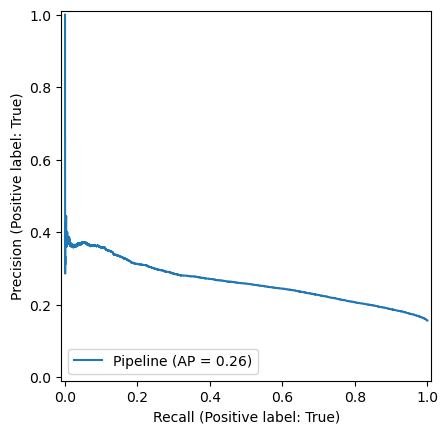

In [11]:
PrecisionRecallDisplay.from_estimator(clf_logit, X_train, y_train,)

### ROC curve ("receiver operating characteristic")

Again, this diagnostic takes all the predicted probabilities the model produces, and pretends we set a threshold of 0.01, 0.02, ... 0.99. For each possible threshold, compute the false positive rate (FPR) and the true positive rate (TPR).

The Y axis is recall for the outcome equal to 1 (charge offs). We want this to equal 1.

The X axis is 1-recall for the outcome equal to 0 (pay backs). We want this to equal 0. By convention, in a ROC curve, 1-recall for outcome 0 is used because this is equal to the false positive rate. False positives are bad!


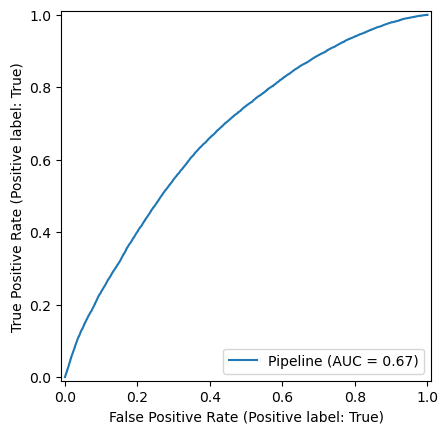

In [12]:
RocCurveDisplay.from_estimator(clf_logit, X_train, y_train)

- This curve shows that you can alter the threshold to reduce false positives, but at the cost of missing some true positives. 
- The perfect estimator is the upper left corner.
- Different estimators will have differently shaped curves, and the closer it gets to the upper left hand corner, the better.
- **"AUC"** reports the area under the curve. 1 is a perfect estimator and 0.5 is a random guess.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/768px-Roc_curve.svg.png"  style="width:50%;"> 




## The problem with our estimator: Imbalance

The issue that is causing this problem is something that is rampant in real business settings: **"Imbalanced classes."**

Meaning: We have 85% and 15% for our two classes (paid off and charged off) instead of 50/50.

Imbalance causes problems with many (though not all) ML estimators.

By default, `sklearn` treats both outcomes as equally important to predict, which is why it favors the majority class (and always predicts no default).

## Options to deal with imbalanced data

1. Manually pick a different threshold. If the predicted probablity is above X%, predict the outcome is positive. The default is 50%. 
1. Change estimator to "weight" groups equally
    - `class-weight=’balanced’` in tree models and logit
    - Is "like" oversampling, except no slowdown
1. Remove data (meaning: undersample overrepresented group)
    - Throws data away (hurts predictions!) but estimations faster
    - Tradeoff can be worth it: more speed and possibly similar or better predictions
1. Add data (meaning: oversample underrepresented group) 
    - Slower estimations (more data)
    
### 🔥🔥🔥 Practical tips: 🔥🔥🔥

- What works best varies between applications (no "dominant")
- **Try weighting if estimator will let you, then undersampling**

### Changing the threshold manually

Let's change the threshold to 0.15 (the avg probability of default in the sample) and see how that affects the confusion matrix.

In [13]:
y_pred_proba = clf_logit.predict_proba(X_train)[:, 1] # get the predicted probabilities
y_mean       = y_train.mean() # get the mean of y_train
y_pred       = (y_pred_proba >= y_mean).astype(int)     # convert to binary predictions
print(classification_report(y_train, y_pred)) 

              precision    recall  f1-score   support

       False       0.91      0.57      0.70     91024
        True       0.23      0.69      0.34     16819

    accuracy                           0.59    107843
   macro avg       0.57      0.63      0.52    107843
weighted avg       0.80      0.59      0.65    107843



### Weighting example

Denying a loan to a good customer is not as bad as giving a loan to a bad customer that defaults. You should probably _weigh_ defaults more heavily.

The `LogisticRegression()` model has a parameter that lets you decide how you weigh the class's importance. You can manually specific them, but `LogisticRegression(class_weight='balanced')` will cause the minority class to be considered equally important overall. (Maybe you want to weigh even more, which you can do by manually setting the weights.)

So, I'm going to change the pipeline (not the logit) to use that parameter. I just need to find out what the _pipeline_ calls that parameter:

In [14]:
# clf_logit.get_params()
# looking for the name of the parameter, as the pipeline calls it


In [15]:
clf_logit.set_params(logisticregression__class_weight='balanced')

clf_logit.fit(X_train, y_train) 
print(classification_report(y_train, 
                            clf_logit.predict(X_train)))

              precision    recall  f1-score   support

       False       0.91      0.57      0.70     91024
        True       0.23      0.69      0.34     16819

    accuracy                           0.59    107843
   macro avg       0.57      0.63      0.52    107843
weighted avg       0.80      0.59      0.65    107843



Hey! We managed to actually predict some defaults! Look:

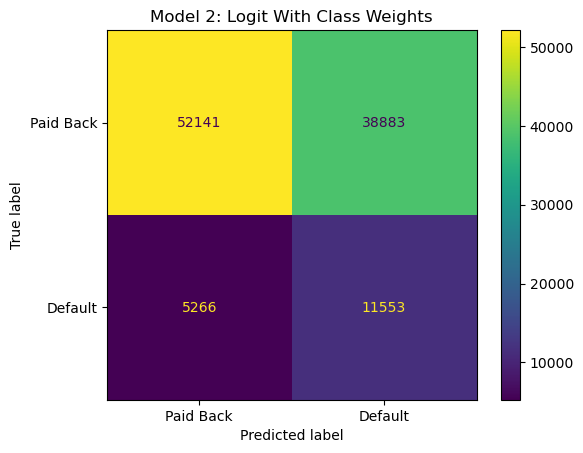

In [16]:

ConfusionMatrixDisplay.from_estimator(clf_logit, X_train, y_train, display_labels=["Paid Back", "Default"])
plt.title('Model 2: Logit With Class Weights')
plt.show()


## Recap before exercises:

We have 5 diagnostics that are useful:

1. Calibration Display: Is your model producing well-tuned probabilities?
1. Classification report: How does the classifier do?
2. Confusion Matrix: Show the prediction counts
4. Precision-Recall Curve: Can your model have high recall and precision if we adjust the threshold?
5. ROC Curve: Can your model have low false positives and high recall if we adjust the threshold? 

Classifiers struggle with imbalanced data.
- We can tell the model to "balance" the classes (balancing their frequency)
- We can pick the threshold

The exercises force us to think about these models as business applications. 

## Exercises 1-5: This is just business math!

For these questions, assume your bank uses automated underwriting: If the model says you'll pay back the loan, they make the loan. 

Make extra (reasonable) assumptions as needed to compare the two models:
1. How much money does M2 save us relative to M1 from reduced charge-offs?
2. How much foregone profit does M2 have relative to M1?
3. Would you rather use M1 or M2 at your bank and why?
4. Write down a profit function for firm. Use the cells of the confusion matrix as variables, as needed. 
    - The four cells of the matrix are TN (upper left), FP (upper right), TP (lower right), FN (lower left)
5. We want to maximize profits, but all the ML diagnostics above are different. Try to rewrite your profit function to include PRECISION OR RECALL.
    - Which do you want to maximize/minimize? 
    - Are any of them equivalent to maximizing profits?


In [17]:
# put answers here


## Exercises 6 and 7: Now we think about reflecting our biz logic in code

6. Prof demo 1: WAIT! We want to max profits! Why are we talking about evaluating precision and recall? Let's just eval profits! 
   - It turns out that the way we "weigh" the classes in the classifier has a economic intuition.
   - In M1, charge offs and pay backs are treated as equally important, and have weight = 1.
   - In M2, charge offs are made to be equally important in terms of **frequency**. 
   - The classifier "upweighs" charge offs to have a weight of 5.7 (0.85/0.15).
   - Let's introduce a third model (M3): Charge offs should be equally important in terms of **economic cost**. 
7. Prof demo 2: Can we just... directly optimize the threshold?

In [18]:
# put answers here

## Bonus demo: Undersampling


In [19]:
# !pip install -U imbalanced-learn

# from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
# from imblearn.under_sampling import RandomUnderSampler

# logit_undersamp = make_pipeline_with_sampler(
#     preproc_pipe,
#     RandomUnderSampler(random_state=42),
#     LogisticRegression(),
# )

# logit_undersamp.fit(X_train, y_train) 

# y_pred = logit_undersamp.predict(X_train,)
# print(classification_report(y_train, y_pred))